In [166]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os
# ML libraries
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
# Tensorflow libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping



In [167]:
tumor_dir = 'Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor'
healthy_dir = 'Brain Tumor Data Set/Brain Tumor Data Set/Healthy'

filepaths = []
labels = []
dict_list = [tumor_dir, healthy_dir]
for i,j in enumerate(dict_list):
    list = os.listdir(j)
    for f in list:
        fpath = os.path.join(j,f)
        filepaths.append(fpath)
        if i ==0:
            labels.append('cancer')
        else:
            labels.append('healthy')

Fseries = pd.Series(filepaths, name = 'filepaths')
Lseries = pd.Series(labels, name = 'labels')
tumor_data = pd.concat([Fseries, Lseries], axis = 1)
tumor_df = pd.DataFrame(tumor_data)
tumor_df.head()

,filepaths,labels
0,Brain Tumor Data Set/Brain Tumor Data Set/Brai...,cancer
1,Brain Tumor Data Set/Brain Tumor Data Set/Brai...,cancer
2,Brain Tumor Data Set/Brain Tumor Data Set/Brai...,cancer
3,Brain Tumor Data Set/Brain Tumor Data Set/Brai...,cancer
4,Brain Tumor Data Set/Brain Tumor Data Set/Brai...,cancer


In [168]:
tumor_df['labels'].value_counts()
tumor_df.shape

(4600, 2)

## Splitting Data 

In [169]:
train_images, test_images = train_test_split(tumor_df, test_size=0.3, random_state=42)
train_set, val_set = train_test_split(tumor_df, test_size=0.2, random_state=42)

In [170]:
print(train_images.shape)
print(test_images.shape)
print(train_set.shape)
print(val_set.shape)

(3220, 2)
(1380, 2)
(3680, 2)
(920, 2)


##  Generate batches of tensor images with real time data augmentation

In [171]:
image_gen = ImageDataGenerator(preprocessing_function = tf.keras.applications.mobilenet_v2.preprocess_input)       
train = image_gen.flow_from_dataframe(dataframe = train_set, x_col = 'filepaths', y_col='labels',
                                     target_size=(244,244),color_mode = 'rgb',
                                     class_mode = 'categorical', batch_size = 32, shuffle = False)
test = image_gen.flow_from_dataframe(dataframe = test_images, x_col = 'filepaths', y_col='labels',
                                    target_size=(244,244),color_mode = 'rgb',
                                    class_mode ='categorical', batch_size = 32, shuffle = False)
val = image_gen.flow_from_dataframe(dataframe = val_set, x_col = 'filepaths', y_col = 'labels',
                                   target_size=(244,244), color_mode = 'rgb', 
                                    class_mode='categorical',batch_size = 32, shuffle = False)

Found 3680 validated image filenames belonging to 2 classes.
Found 1380 validated image filenames belonging to 2 classes.
Found 920 validated image filenames belonging to 2 classes.


In [172]:
class1 = (train.class_indices.keys()) 
print(class1)

dict_keys(['cancer', 'healthy'])


## Visulaizing Images 

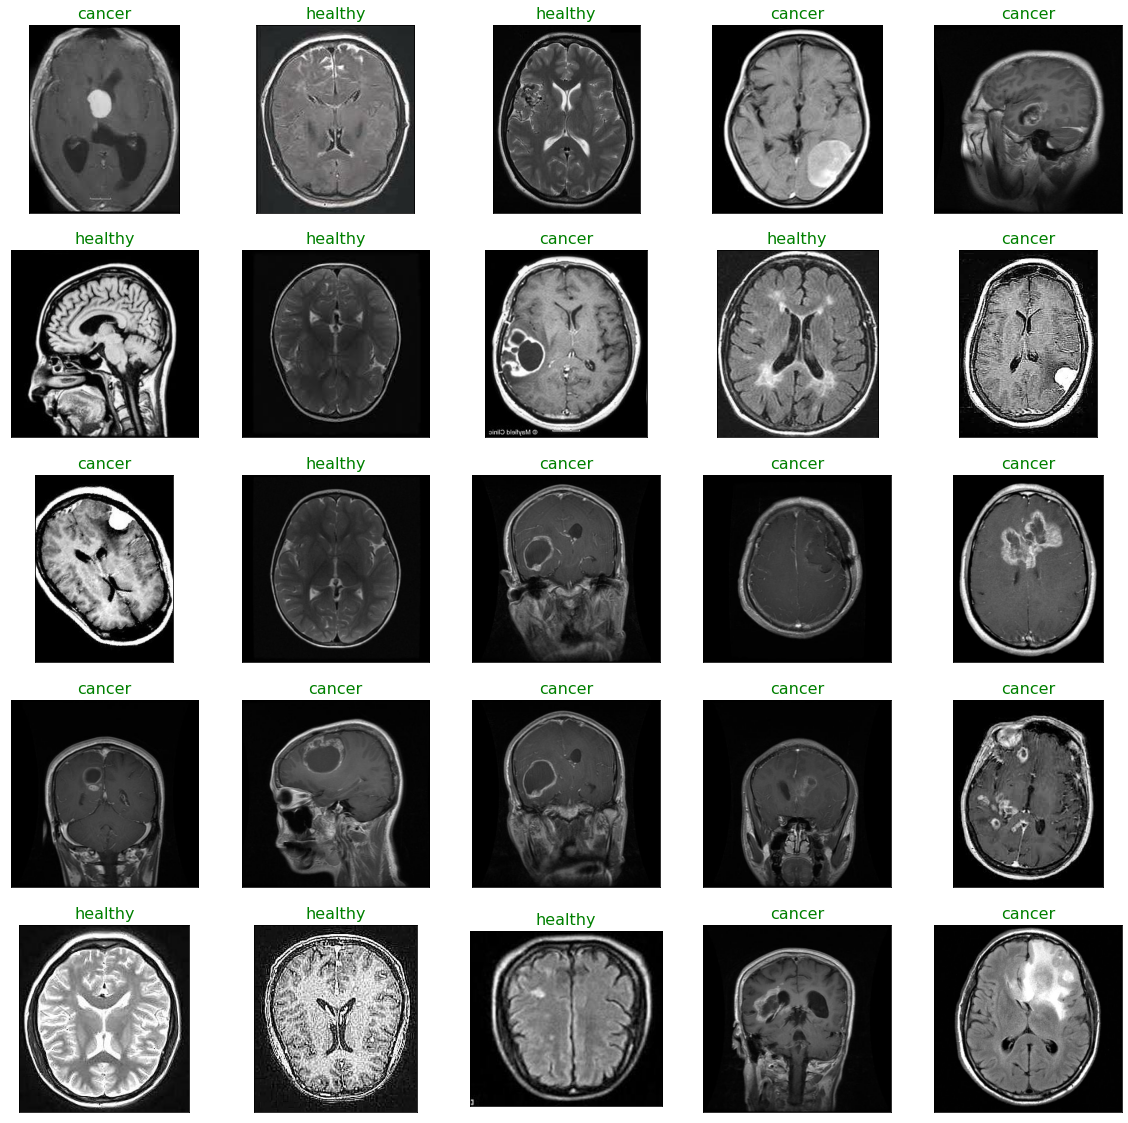

In [173]:
length = len(labels)
if length < 25:
    r = length
else:
    r = 25
plt.figure(figsize=(20,20))
for i in range(r):
    random = np.random.randint(1,len(tumor_df))
    plt.subplot(5,5,i+1)
    plt.imshow(cv2.imread(tumor_df.loc[random,"filepaths"]))
    plt.title(tumor_df.loc[random, "labels"], fontsize = 16, color = "green") 
    plt.xticks([])
    plt.yticks([])
    
plt.show()
